[AUTO-ROI] Detected region: x=539, y=486, w=917, h=563
Final motion heatmap saved as 'motion_heatmap_final.png'
Video Summary
--------------
Total Frames: 326
Estimated BPM: 72.00
Rhythm Quality Index (lower is better): 0.4346
Motion Stability Score: 0.9998
Estimated BPM: 72.00


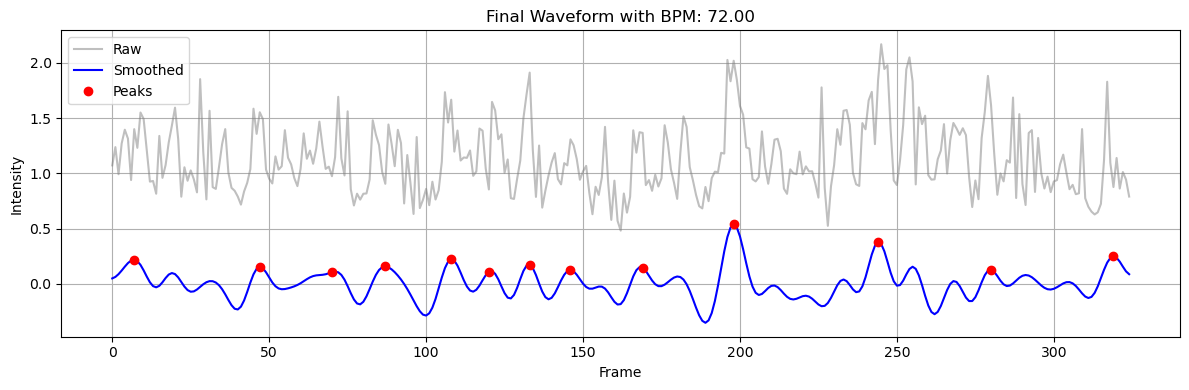

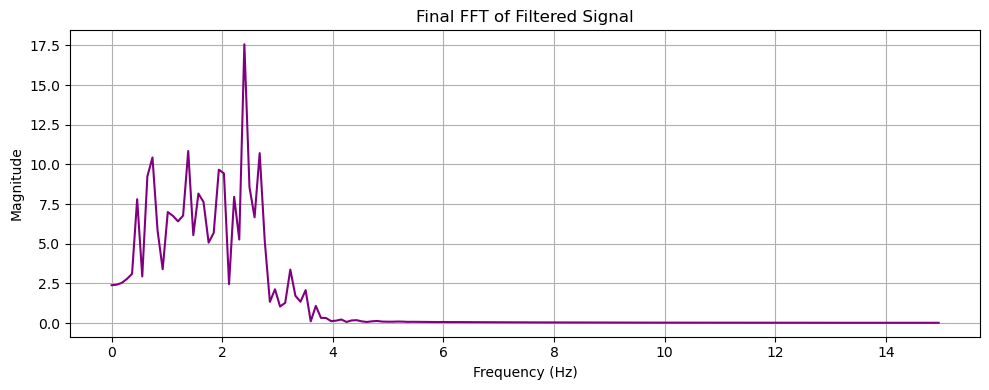

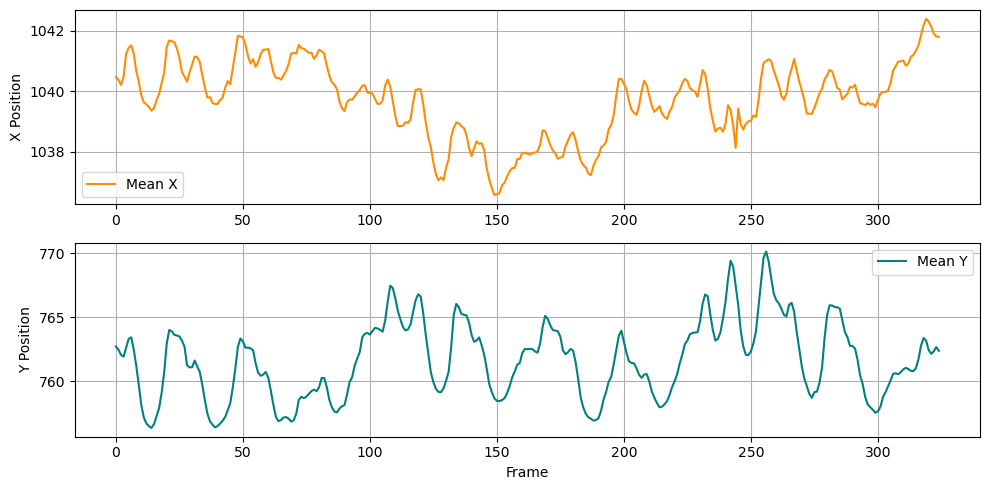

Pulse Interpretation Report
---------------------------
- The BPM is 72.0, indicating a normal resting pulse.
- Pulse rhythm is irregular, indicating possible beat-to-beat variability or noise.
- The motion in the region is highly stable, suggesting good fixation and signal clarity.


In [26]:
# ==========================
# Neck Pulse Motion Analysis
# ==========================
# This script processes a neck video to track skin motion due to pulse, estimate BPM,
# analyze rhythm and stability, generate visual overlays, and output interpretations.

import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from scipy.signal import butter, filtfilt, find_peaks
from scipy.ndimage import uniform_filter1d, gaussian_filter1d

# === Signal Preprocessing ===
# Applies a bandpass filter to isolate physiological motion signal (heartbeats).
def bandpass_filter(signal, lowcut=0.5, highcut=3.0, fs=30.0, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="band")
    return filtfilt(b, a, signal)

# === Draw Signal on Canvas for Embedding ===
# Converts motion signal into an image to embed in video overlay.
def plot_mini_signal(signal, width=400, height=150):
    fig, ax = plt.subplots(figsize=(width/100, height/100), dpi=100)
    ax.plot(signal, color='green')
    ax.set_title('Live Waveform', fontsize=9)
    ax.set_xlabel('Frame')
    ax.set_ylabel('Motion')
    ax.grid(True)
    canvas = FigureCanvas(fig)
    canvas.draw()
    buf = np.frombuffer(canvas.buffer_rgba(), dtype=np.uint8)
    w, h = fig.canvas.get_width_height()
    canvas_img = buf.reshape(h, w, 4)[..., :3]
    plt.close(fig)
    return canvas_img

# === BPM Estimation ===
# Identifies peaks in the smoothed motion signal to calculate BPM.
def estimate_bpm(signal, frame_rate):
    smoothed = gaussian_filter1d(signal, sigma=2)
    max_bpm_allowed = 240
    max_peak_freq = max_bpm_allowed / 60.0
    min_distance = int(frame_rate / max_peak_freq)
    signal_std = np.std(smoothed)
    signal_mean = np.mean(smoothed)
    signal_range = np.max(smoothed) - np.min(smoothed)
    prominence_thresh = max(0.05, 0.1 * signal_range)
    height_thresh = signal_mean + 0.3 * signal_std
    peaks, _ = find_peaks(smoothed, distance=min_distance, prominence=prominence_thresh, height=height_thresh)
    duration_sec = len(smoothed) / frame_rate
    bpm = (len(peaks) / duration_sec) * 60
    return bpm, peaks


# === Video Processing ===
# === Main Processing Function ===
# This function captures the core of real-time motion tracking, signal extraction,
# live waveform generation, visual overlay, and saving the annotated video output.
# Additional metrics like rhythm regularity, stability, and frequency domain info
# are computed and saved at the end.
def process_video(video_path):
    global bpm, rhythm_quality, stability
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter('nerve_motion_output.avi', fourcc, fps, (960, 540))
    fps = cap.get(cv2.CAP_PROP_FPS)
    ret, first_frame = cap.read()
    if not ret:
        print("Error reading video")
        return

    h, w = first_frame.shape[:2]
    first_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
    motion_accum = np.zeros_like(first_gray, dtype=np.float32)
    temp_cap = cv2.VideoCapture(video_path)
    ret, prev_frame = temp_cap.read()
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

    for _ in range(30):
        ret, frame = temp_cap.read()
        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        diff = cv2.absdiff(prev_gray, gray).astype(np.float32)
        motion_accum += diff
        prev_gray = gray.copy()

    motion_norm = cv2.normalize(motion_accum, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    _, motion_thresh = cv2.threshold(motion_norm, 25, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(motion_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, rw, rh = cv2.boundingRect(largest_contour)
        print(f"[AUTO-ROI] Detected region: x={x}, y={y}, w={rw}, h={rh}")
    else:
        print("⚠️ No motion detected. Using full frame.")
        x, y, rw, rh = 0, 0, w, h

    temp_cap.release()

    roi_initial = first_gray[y:y+rh, x:x+rw]
    p0 = cv2.goodFeaturesToTrack(roi_initial, maxCorners=200, qualityLevel=0.3, minDistance=5, blockSize=7)
    if p0 is not None:
        p0[:, 0, 0] += x
        p0[:, 0, 1] += y

    motion_signal = []
    heatmap_accum = np.zeros((h, w), dtype=np.float32)
    prev_gray = first_gray.copy()

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame_diff = cv2.absdiff(gray, prev_gray)
        diff = np.mean(frame_diff)
        motion_signal.append(diff)
        heatmap_accum += frame_diff.astype(np.float32)

        if p0 is not None:
            p1, st, err = cv2.calcOpticalFlowPyrLK(prev_gray, gray, p0, None)
            if p1 is not None:
                good_new = p1[st == 1]
                good_old = p0[st == 1]
                for i, (new, old) in enumerate(zip(good_new, good_old)):
                    a, b = new.ravel().astype(int)
                    frame = cv2.circle(frame, (a, b), 3, (0, 0, 255), 3)

                # Draw spider web style connections from each point to a local center
                center_x = int(np.mean(good_new[:, 0]))
                center_y = int(np.mean(good_new[:, 1]))
                for new in good_new:
                    a, b = new.ravel().astype(int)
                    frame = cv2.line(frame, (a, b), (center_x, center_y), (0, 255, 255), 2)

                # Connect outer points to form a closed polygonal web
                if len(good_new) >= 3:
                    hull = cv2.convexHull(good_new.astype(np.float32), returnPoints=True)
                    for i in range(len(hull)):
                        pt1 = tuple(hull[i % len(hull)][0].astype(int))
                        pt2 = tuple(hull[(i + 1) % len(hull)][0].astype(int))
                        frame = cv2.line(frame, pt1, pt2, (0, 200, 255), 2)

                p0 = good_new.reshape(-1, 1, 2)

        prev_gray = gray.copy()

        if len(motion_signal) > int(fps * 2):
            filtered = bandpass_filter(motion_signal, fs=fps)
            smoothed = uniform_filter1d(filtered, size=3)
            signal_to_plot = smoothed[-100:]
        else:
            signal_to_plot = motion_signal[-100:]

            # === FFT Plot ===
        fft_vals = np.abs(np.fft.rfft(signal_to_plot))
        fft_freqs = np.fft.rfftfreq(len(signal_to_plot), d=1/fps)
        fig_fft, ax_fft = plt.subplots(figsize=(3, 1.5), dpi=100)
        ax_fft.plot(fft_freqs, fft_vals, color='magenta')
        ax_fft.set_title('Live FFT', fontsize=9)
        ax_fft.set_xlabel('Hz')
        ax_fft.set_ylabel('Amplitude')
        ax_fft.grid(True)
        canvas_fft = FigureCanvas(fig_fft)
        canvas_fft.draw()
        buf_fft = np.frombuffer(canvas_fft.buffer_rgba(), dtype=np.uint8)
        w_fft, h_fft = fig_fft.canvas.get_width_height()
        fft_img = buf_fft.reshape(h_fft, w_fft, 4)[..., :3]
        plt.close(fig_fft)
        fft_img_resized = cv2.resize(fft_img, (300, 150))
        signal_img = plot_mini_signal(signal_to_plot, width=500, height=200)
        signal_img_resized = cv2.resize(signal_img, (300, 150))

        frame_with_box = cv2.resize(frame.copy(), (960, 540))
        h_wave, w_wave = signal_img_resized.shape[:2]
        frame_with_box[10:10+h_wave, 10:10+w_wave] = signal_img_resized
        frame_with_box[10:10+fft_img_resized.shape[0], 10+w_wave+10:10+w_wave+10+fft_img_resized.shape[1]] = fft_img_resized
        frame_num = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cv2.putText(frame_with_box, f"Frame: {frame_num}/{total_frames}", (10, h_wave + 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA)
        cv2.putText(frame_with_box, f"Intensity: {diff:.2f}", (10, h_wave + 60),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA)

        heatmap_resized_accum = cv2.resize(heatmap_accum, (960, 540))
        heatmap_norm = cv2.normalize(heatmap_resized_accum, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        heatmap_color = cv2.applyColorMap(heatmap_norm, cv2.COLORMAP_JET)
        heatmap_resized = cv2.resize(heatmap_color, (200, 150))
        x_start = max(960 - heatmap_resized.shape[1] - 10, 0)
        x_end = x_start + heatmap_resized.shape[1]
        frame_with_box[10:10+heatmap_resized.shape[0], x_start:x_end] = heatmap_resized

        out.write(frame_with_box)
        cv2.imshow('Nerve Motion Tracking', frame_with_box)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    out.release()
    cv2.destroyAllWindows()

    # === Save Final Heatmap Frame ===
    heatmap_final = cv2.normalize(heatmap_accum, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    heatmap_final_color = cv2.applyColorMap(heatmap_final, cv2.COLORMAP_JET)
    cv2.imwrite("motion_heatmap_final.png", heatmap_final_color)
    print("Final motion heatmap saved as 'motion_heatmap_final.png'")

    # === Optionally display final heatmap ===
    cv2.imshow("Final Motion Heatmap", heatmap_final_color)
    cv2.waitKey(0)
    cv2.destroyWindow("Final Motion Heatmap")

        # === Save X and Y Tracker Motion Over Time ===
    # Re-analyzes the video to compute the mean position (X, Y) of all good features across each frame
    # This helps visualize the general displacement of tracked points over time
    if 'good_old' in locals():
        tracker_x = []
        tracker_y = []
        cap_track = cv2.VideoCapture(video_path)
        cap_track.set(cv2.CAP_PROP_POS_FRAMES, 1)
        prev_gray_track = first_gray.copy()
        p_track = p0.copy()
        while True:
            ret, frame_track = cap_track.read()
            if not ret:
                break
            gray_track = cv2.cvtColor(frame_track, cv2.COLOR_BGR2GRAY)
            p_next, st, err = cv2.calcOpticalFlowPyrLK(prev_gray_track, gray_track, p_track, None)
            if p_next is not None:
                good_track = p_next[st == 1]
                mean_x = np.mean(good_track[:, 0])
                mean_y = np.mean(good_track[:, 1])
                tracker_x.append(mean_x)
                tracker_y.append(mean_y)
                p_track = good_track.reshape(-1, 1, 2)
                prev_gray_track = gray_track.copy()
        cap_track.release()
    
    # === Rhythm Quality Index ===
    # Calculates the regularity of pulse peaks using the standard deviation of intervals
    # A lower value indicates more consistent rhythm (closer to a healthy or resting pulse)
    filtered = bandpass_filter(motion_signal, fs=fps)
    smoothed = gaussian_filter1d(filtered, sigma=2)
    bpm, peaks = estimate_bpm(smoothed, fps)
    
    if len(peaks) > 2:
        peak_intervals = np.diff(peaks)
        rhythm_quality = np.std(peak_intervals) / np.mean(peak_intervals)
    else:
        rhythm_quality = float('nan')
    
    # === Motion Stability ===
    # Measures the steadiness of tracked points. High stability indicates accurate measurement conditions.
    if 'good_old' in locals() and 'good_new' in locals() and len(good_new) > 0:
        displacement = np.linalg.norm(good_new - good_old, axis=1)
        stability = 1 - np.mean(displacement) / (rw + rh)
    else:
        stability = float('nan')
    
    # === Timeline Progress Summary ===
    # Displays an overview of video length and key physiological measurements
    print("Video Summary")
    print("--------------")
    print(f"Total Frames: {int(total_frames)}")
    print(f"Estimated BPM: {bpm:.2f}")
    print(f"Rhythm Quality Index (lower is better): {rhythm_quality:.4f}")
    print(f"Motion Stability Score: {stability:.4f}")
    
    # Prepare mean coordinates for CSV
    xc = []
    yc = []
    for i, (xv, yv) in enumerate(zip(tracker_x, tracker_y)):
        xc.append(xv)
        yc.append(yv)
    
    # === Save CSV ===
    # Exports all per-frame data including signal, filtered values, peak flag, and motion coordinates
    import csv
    with open('live_motion_log.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Frame', 'Raw_Intensity', 'Filtered_Intensity', 'Is_Peak', "x_cord", "y_cord"])
        for i in range(len(motion_signal)):
            is_peak = 1 if i in peaks else 0
            filtered_val = smoothed[i] if i < len(smoothed) else ''
            writer.writerow([i+1, motion_signal[i], filtered_val, is_peak, xc[i], yc[i]])
    
    # === Final BPM Recheck and Waveform Plot ===
    # Renders the complete smoothed signal, raw trace, and detected peaks to validate signal quality
    filtered = bandpass_filter(motion_signal, fs=fps)
    smoothed = gaussian_filter1d(filtered, sigma=2)
    bpm, peaks = estimate_bpm(smoothed, fps)
    print(f"Estimated BPM: {bpm:.2f}")
    
    plt.figure(figsize=(12, 4))
    plt.plot(motion_signal, alpha=0.5, label='Raw', color='gray')
    plt.plot(smoothed, label='Smoothed', color='blue')
    plt.plot(peaks, smoothed[peaks], 'ro', label='Peaks')
    plt.title(f'Final Waveform with BPM: {bpm:.2f}')
    plt.xlabel('Frame')
    plt.ylabel('Intensity')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # === Final FFT Plot ===
    # Displays the frequency content of the filtered signal for cross-validation of BPM
    fft_vals_final = np.abs(np.fft.rfft(filtered))
    fft_freqs_final = np.fft.rfftfreq(len(filtered), d=1/fps)
    plt.figure(figsize=(10, 4))
    plt.plot(fft_freqs_final, fft_vals_final, color='purple')
    plt.title('Final FFT of Filtered Signal')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # === X/Y Displacement Plot ===
    # Shows how the tracked features move in the X and Y direction over time
    plt.figure(figsize=(10, 5))
    plt.subplot(2, 1, 1)
    plt.plot(tracker_x, label='Mean X', color='darkorange')
    plt.ylabel('X Position')
    plt.grid(True)
    plt.legend()
    plt.subplot(2, 1, 2)
    plt.plot(tracker_y, label='Mean Y', color='teal')
    plt.ylabel('Y Position')
    plt.xlabel('Frame')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# === Automated Pulse Report ===
def interpret_pulse_report(bpm, rhythm_quality, stability):
    story = []
    if bpm < 60:
        story.append(f"The pulse is slow at {bpm:.1f} BPM, which might suggest bradycardia if persistent.")
    elif 60 <= bpm <= 100:
        story.append(f"The BPM is {bpm:.1f}, indicating a normal resting pulse.")
    else:
        story.append(f"The pulse is elevated at {bpm:.1f} BPM, suggesting a faster-than-normal heart rate.")

    if rhythm_quality < 0.1:
        story.append("The rhythm quality is highly consistent, showing a very regular pulse.")
    elif rhythm_quality < 0.25:
        story.append("The rhythm is relatively stable, with minor variability in pulse intervals.")
    else:
        story.append("Pulse rhythm is irregular, indicating possible beat-to-beat variability or noise.")

    if stability > 0.8:
        story.append("The motion in the region is highly stable, suggesting good fixation and signal clarity.")
    elif stability > 0.6:
        story.append("Motion stability is moderate. Some drift or tremor may be affecting precision.")
    else:
        story.append("Motion appears unstable, potentially reducing the accuracy of pulse interpretation.")

    # === Deep Insights ===
    if bpm > 100 and rhythm_quality < 0.25:
        story.append("Elevated pulse with relatively stable rhythm may indicate a heightened physiological state (e.g., stress or physical exertion).")
    if bpm > 100 and stability < 0.5:
        story.append("High BPM with unstable motion may be due to measurement artifacts rather than physiological cause.")
    if bpm < 60 and rhythm_quality < 0.3:
        story.append("Slow but consistent pulse may reflect physiological bradycardia seen in athletes or relaxed states.")
    if np.isnan(rhythm_quality) or np.isnan(stability):
        story.append("Signal confidence may be low due to poor tracker stability or insufficient peak detection.")

    print("Pulse Interpretation Report")
    print("---------------------------")
    for line in story:
        print("- " + line)

process_video("neck.mp4")

# === Run Interpretation Automatically ===
interpret_pulse_report(bpm, rhythm_quality, stability)
